<a href="https://www.kaggle.com/code/victorkingau/autoencoders?scriptVersionId=183470930" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import os
import numpy as np
import glob
import torch
import torch.nn as nn
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import cv2
import torch.functional as F
from io import open
from PIL import Image
from numpy import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
#from torchsummary import summary
from torch.nn import Linear, ReLU, MSELoss, L1Loss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, AdaptiveAvgPool2d, Module, BatchNorm2d, Sigmoid, Dropout
from torchvision import transforms

splitting the dataset into train val and test

In [32]:
!unzip /kaggle/working/denoised.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /kaggle/working/denoised.zip
   creating: kaggle/working/denoised/
   creating: kaggle/working/denoised/ICIP_test_data_final/
   creating: kaggle/working/denoised/ICIP_test_data_final/RawDataQA (15)/
  inflating: kaggle/working/denoised/ICIP_test_data_final/RawDataQA (15)/(212).tif  
  inflating: kaggle/working/denoised/ICIP_test_data_final/RawDataQA (15)/(66).tif  
  inflating: kaggle/working/denoised/ICIP_test_data_final/RawDataQA (15)/(171).tif  
  inflating: kaggle/working/denoised/ICIP_test_data_final/RawDataQA (15)/(62).tif  
  inflating: kaggle/working/denoised/ICIP_test_data_final/RawDataQA (15)/(95).tif  
  inflating: kaggle/working/denoised/ICIP_test_data_final/RawDataQA (15)/(142).tif  
  inflating: kaggle/working/denoised/ICIP_test_data_final/RawDataQA (15)/(104).tif  
  inflating: kaggle/working/denoised/ICIP_test_data_final/RawDataQA (15)/(98).tif  
  inflating: kaggle/working/denoised/ICIP_test_data_final/RawDataQA (15)/(202).tif  
  inflating: kaggle/working/d

In [4]:
# Import helper functions
def split_dir_to_train_test_val(directory = "images/",
                            train_size = 0.7,
                            test_size = 0.2,
                            val_size = 0.1):
      """
      Creates 3 folders for Train, Test and Validation data
      """
      import os
      import random
      import shutil
    
      # Set random seed
      rng = random.Random(42)
    
      for root, folders, files in os.walk(directory):
        for folder in folders:
          # Create list of the files
          list_of_files = []
          for file_name in os.listdir(root+folder+"/"):
            list_of_files.append(file_name)
          
          #  Shuffle the list
          rng.shuffle(list_of_files)
    
          # Create lists of files
          train_files = list_of_files[:int(len(list_of_files)*train_size)]
          test_files = list_of_files[int(len(list_of_files)*train_size) : int(len(list_of_files)*(train_size+test_size))]
          val_files = list_of_files[int(len(list_of_files)*(train_size+test_size)):]
    
          # Create folders and files for train data
          for one_file in train_files:
          
            # Copy  files
            dest_dir = "files/train/"+folder+"/"
            os.makedirs(dest_dir, exist_ok=True)
    
            shutil.copy2(src=(root+folder+"/"+one_file),
                        dst=(dest_dir+one_file))
          print(f"Folder {folder}. Train data copied. {len(train_files)} files")
    
          # Create folders and files for test data
          for one_file in test_files:      
            # Copy  files
            dest_dir = "files/test/"+folder+"/"
            os.makedirs(dest_dir, exist_ok=True)
    
            shutil.copy2(src=(root+folder+"/"+one_file),
                        dst=(dest_dir+one_file))
          print(f"Folder {folder}. Test data copied. {len(test_files)} files")
    
          # Create folders and files for validation data
          for one_file in val_files:
          
            # Copy  files
            dest_dir = "files/validation/"+folder+"/"
            os.makedirs(dest_dir, exist_ok=True)
    
            shutil.copy2(src=(root+folder+"/"+one_file),
                        dst=(dest_dir+one_file))
          print(f"Folder {folder}. Validation data copied. {len(val_files)} files")
      
     


def get_class_names(directory):
      """
      Get the classnames from train folder for example
      """
      import pathlib
      import numpy as np
      data_dir = pathlib.Path(directory)
      class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class names 
      return class_names
      print(class_names)

In [5]:
split_dir_to_train_test_val(directory = "/kaggle/input/oct-classification-data/classification data/",
                            train_size = 0.7,
                            test_size = 0.2,
                            val_size = 0.1)

Folder 2. Train data copied. 3194 files
Folder 2. Test data copied. 913 files
Folder 2. Validation data copied. 457 files
Folder 0. Train data copied. 5763 files
Folder 0. Test data copied. 1647 files
Folder 0. Validation data copied. 824 files
Folder 1. Train data copied. 3667 files
Folder 1. Test data copied. 1048 files
Folder 1. Validation data copied. 525 files


In [6]:
transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(300,300)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Grayscale(1)
])

the dataloader

In [7]:
train_path = '/kaggle/working/files/train' #path to the folder to be fed into the dataloader
test_path = '/kaggle/working/files/test'
val_path = '/kaggle/working/files/validation'

train_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform = transform),
    batch_size = 32,
    shuffle = True
)
test_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform = transform),
    batch_size = 32,
    shuffle = True
)
val_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(val_path, transform = transform),
    batch_size = 32,
    shuffle = True
)

In [8]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image, cmap = 'gray')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<Axes: >

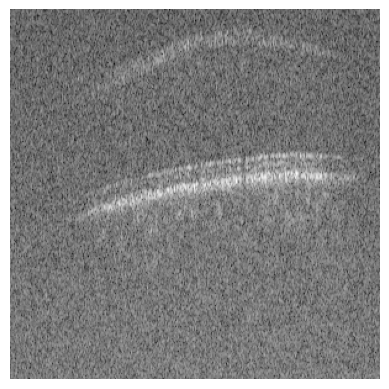

In [9]:
# Visualizing an image from the dataset
images, _ = next(iter(val_dataloader))
imshow(images[1], normalize=False)

Additive noise

<Axes: >

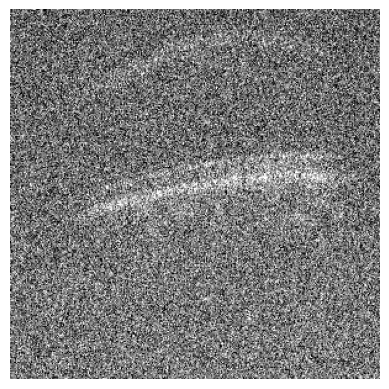

In [10]:
noisy_images = (images + torch.normal(0,0.2, images.shape)).clip(0,1)
imshow(noisy_images[1], normalize=False)

In [ ]:
!pip install bm3d torchsummary

poisson noise

<Axes: >

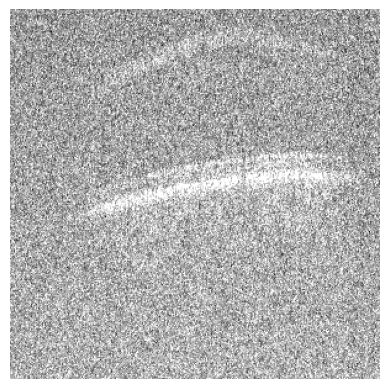

In [11]:
a = 5*torch.ones(images.shape)
p = torch.poisson(a)
p_norm = p/p.max()

poisson_noisy_images = (images + p_norm).clip(0,1)
imshow(poisson_noisy_images[1], normalize=False)

In [12]:
EPS = 1e-8
def PSNR(input, target):
    return -10*torch.log10(torch.mean((input - target) ** 2, dim=[1, 2, 3])+EPS)
def MSE(input, target):
    return torch.mean((input - target) ** 2, dim=[1, 2, 3])

In [13]:
PSNR(images, noisy_images)

tensor([14.1591, 14.1522, 14.2247, 14.1757, 14.1767, 14.1934, 14.2225, 14.1570,
        14.1432, 14.1832, 14.2302, 14.2360, 14.1116, 14.1738, 14.2052, 14.2917,
        14.2365, 14.1710, 14.1856, 14.1733, 14.2151, 14.1876, 14.1835, 14.1654,
        14.2036, 14.1652, 14.2061, 14.2026, 14.2953, 14.2248, 14.1701, 14.1304])

In [ ]:
import bm3d
denoised_image = bm3d.bm3d(noisy_images[1].permute(1,2,0), sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

In [ ]:
plt.imshow(denoised_image, cmap = 'gray')

In [16]:

class autoencoders(nn.Module):
    def __init__(self):
        super(autoencoders, self).__init__()
        self.encoder = Sequential(
            Conv2d(1, 32, kernel_size = (3,3), padding = "same"),
            ReLU(),
            MaxPool2d((2,2), padding = 0),
            Conv2d(32, 64, kernel_size = (3,3), padding = "same"),
            ReLU(),
            MaxPool2d((2,2), padding = 0),
            Conv2d(64, 128, kernel_size = (3,3), padding = "same"),
            ReLU(),
            MaxPool2d((2,2), padding = 0)
        )
        self.decoder = Sequential(
            ConvTranspose2d(128, 128, kernel_size = (3,3), stride = 2, padding = 0),
            ReLU(),
            ConvTranspose2d(128, 64, kernel_size = (3,3), stride = 2, padding = 1, output_padding = 1),
            ReLU(),
            ConvTranspose2d(64, 32, kernel_size = (3,3), stride = 2, padding = 1, output_padding = 1),
            ReLU(),
            ConvTranspose2d(32, 1, kernel_size = (3,3), stride = 1, padding = 1),
            Sigmoid()
        )
        
    def forward(self, images):
        x = self.encoder(images)
        x = self.decoder(x)
        return x

In [ ]:
print(summary(autoencoders().to(device),(1,300,300), 32))

In [ ]:
loss_module = MSELoss()

In [ ]:
def eval_model(model, val_dataloader, noise_type, noise_parameter):
    model.eval()
    psnr = []
    mse = []
    with torch.no_grad():
        for images, _ in val_dataloader:
            if (noise_type == "normal"):
                noisy_images = (images + torch.normal(0,noise_parameter,images.shape)).clip(0,1)
            elif (noise_type == "poisson"):
                a = noise_parameter*torch.ones(images.shape)
                p = torch.poisson(a)
                p_norm = p/p.max()
                noisy_images = (images + p_norm).clip(0,1)
            images = images.to(device)
            noisy_images = noisy_images.to(device)
            preds = model(images)
            psnr.extend(PSNR(images.cpu().detach(), preds.cpu().detach()))
            mse.extend(MSE(images.cpu().detach(), preds.cpu().detach()))
        print(f"Peak Signal to Noise Ratio:   Mean: {np.array(psnr).mean()} || Std: {np.array(psnr).std()}")
        print(f"Mean Squared Error:   Mean: {np.array(mse).mean()} || Std: {np.array(mse).std()}")
        return np.array(psnr).mean(), np.array(mse).mean()

In [ ]:
def train_model(model, noise_type, noise_parameter, optimizer, train_dataloader, val_dataloader, loss_module, target_type="clean", num_epochs=30):
    model.train()
    epoch_num = []
    mse_train = []
    mse_val = []
    psnr_train = []
    psnr_val = []
    mse = 0.0
    psnr = 0.0
    for epoch in range(num_epochs):
        for images, _ in train_dataloader:
            targets = torch.clone(images)
            if (noise_type == "normal"):
                images = (images + torch.normal(0,noise_parameter,images.shape)).clip(0,1)
            elif (noise_type == "poisson"):
                a = noise_parameter*torch.ones(images.shape)
                p = torch.poisson(a)
                p_norm = p/p.max()
                images = (images + p_norm).clip(0,1)
            if (target_type == "noisy"):
                if (noise_type == "normal"):
                    targets = (targets + torch.normal(0,noise_parameter,targets.shape)).clip(0,1)
                elif (noise_type == "poisson"):
                    a = noise_parameter*torch.ones(targets.shape)
                    p = torch.poisson(a)
                    p_norm = p/p.max()
                    targets = (targets + p_norm).clip(0,1)           
            images = images.to(device)
            targets = targets.to(device)
            preds = model(images)
            loss = loss_module(preds, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch%3 == 0):
            print(f"********EPOCH {epoch+1}:********")
            epoch_num.append(epoch+1)
            print("Train set:")
            psnr, mse = eval_model(model, train_dataloader, noise_type, noise_parameter)
            psnr_train.append(psnr)
            mse_train.append(mse)
            print("Validation set:")
            psnr, mse = eval_model(model, val_dataloader, noise_type, noise_parameter)
            
            psnr_val.append(psnr)
            mse_val.append(mse)

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


In [17]:
normal_ae_mse = autoencoders()
normal_optimizer_mse = Adam(normal_ae_mse.parameters(), lr=1e-3)
normal_ae_mse = normal_ae_mse.to(device)

In [ ]:
#poisson_ae = autoencoders()
#poisson_optimizer = Adam(poisson_ae.parameters(), lr=1e-3)
#poisson_ae = poisson_ae.to(device)

In [ ]:
%%time
train_model(normal_ae_mse, "normal", 0.2, normal_optimizer_mse, train_dataloader, val_dataloader, loss_module)

testing the model

In [18]:
normal_ae_mse.eval()
images, _ = next(iter(val_dataloader))
images = images.float().to(device)



<Axes: >

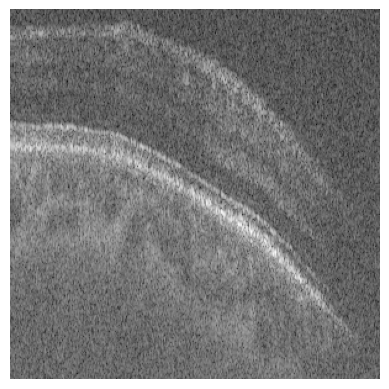

In [19]:
imshow(images[3].cpu().detach(), normalize=False)

In [20]:
output = normal_ae_mse(images.to(device))

<Axes: >

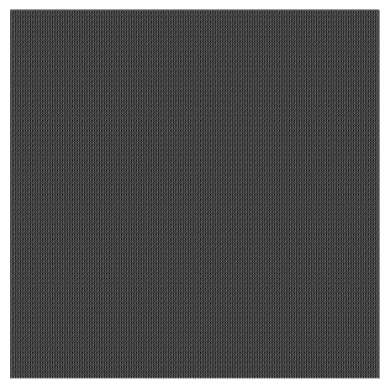

In [21]:
imshow(output[3].cpu().detach(), normalize=False)

In [ ]:
torch.save(normal_ae_mse.state_dict(),'pytorch_denoising.model')

In [22]:
def PSNR(original, denoiced): 
    mse = torch.mean((original - denoiced) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20*torch.log10(torch.tensor(max_pixel, dtype = torch.float32) - 10 * torch.log10(mse) )
    return psnr 

# how does it look on the test data ?!?

In [24]:
checkpoint = torch.load('/kaggle/working/pytorch_denoising.model', map_location = device)
model = autoencoders()
normal_optimizer_mse = Adam(normal_ae_mse.parameters(), lr=1e-3)
model = normal_ae_mse.to(device)

model.load_state_dict(checkpoint)
model.eval()

autoencoders(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 1, kernel_size=(3, 3)

In [25]:
test_path = '/kaggle/input/test-data-2'
test_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform = transform),
)
test_images, _ = next(iter(test_dataloader))
test_images = images.float().to(device)

<Axes: >

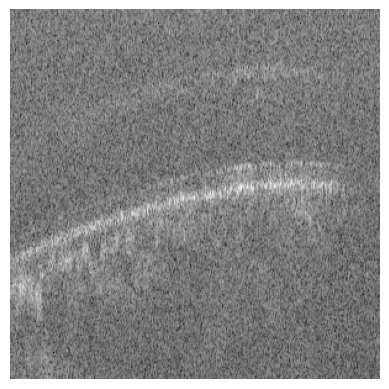

In [26]:
imshow(test_images[6].cpu().detach(), normalize=False)

In [27]:
input_path = '/kaggle/input/test-data-2/ICIP_test_data_final/RawDataQA (10)/(103).tif'
test_image = Image.open(input_path).convert('L') 
test_image = transform(test_image).unsqueeze(0)
output = model(test_image.to(device))
output = transforms.ToPILImage()(output.squeeze(0))

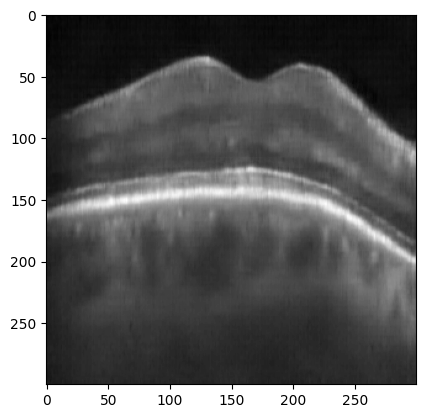

In [28]:
plt.imshow(output, cmap = 'gray')

let's see the PSNR

In [29]:
PSNR(test_images, output)

TypeError: unsupported operand type(s) for -: 'Tensor' and 'Image'

In [30]:
def process_images(root_folder, autoencoder, output_folder, device):
    """
    Process images in root_folder using the provided autoencoder and save the output in output_folder.
    
    Args:
    - root_folder (str): Root folder containing images.
    - autoencoder (torch.nn.Module): PyTorch autoencoder model.
    - output_folder (str): Folder to save processed images.
    """
    # Define transformation to preprocess images
    transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.Grayscale(),# Resize images to fit the model input size
        transforms.ToTensor()           # Convert images to tensors
    ])
    
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Iterate through root folder and subfolders
    for root, _, files in os.walk(root_folder):
        for file in files:
            # Check if file is an image
            if file.lower().endswith(('.tiff')):
                # Construct input and output file paths
                input_path = os.path.join(root, file)
                rel_path = os.path.relpath(input_path, root_folder)
                output_path = os.path.join(output_folder, rel_path)
                
                # Create directory structure for output path if it doesn't exist
                output_dir = os.path.dirname(output_path)
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                
                # Load and preprocess image
                image = Image.open(input_path).convert('L') 
                image = transform(image).unsqueeze(0)
                
                # Pass image through autoencoder
                with torch.no_grad():
                    decoded = autoencoder(image.to(device))
                
                # Convert tensor back to image and save
                decoded_image = transforms.ToPILImage()(decoded.squeeze(0))
                decoded_image = decoded_image.convert('L')
                decoded_image.save(output_path)


In [31]:
#!rm -rf /kaggle/working/denoised-train
root_folder = '/kaggle/input/oct-classification-data/classification data'
process_images(root_folder, model, 'denoised-train/', device)

KeyboardInterrupt: 

In [ ]:
img  = cv2.imread('/kaggle/working/denoised/ICIP_test_data_final/RawDataQA (10)/(103).tif')
plt.imshow(img)

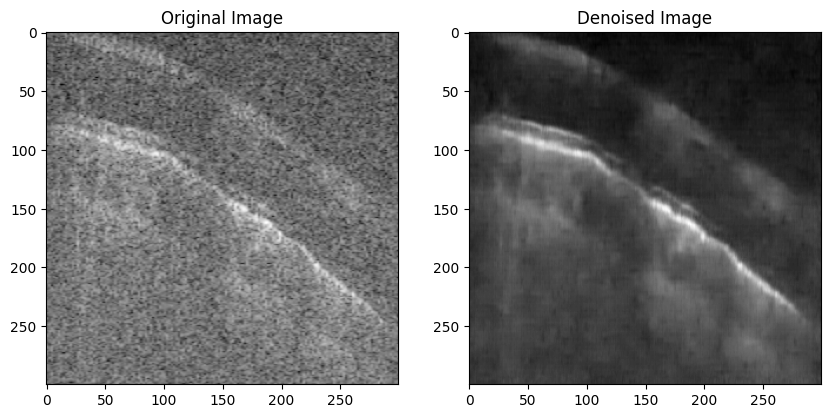

In [67]:
import matplotlib.pyplot as plt
import cv2

eval_img = []
def display_images_side_by_side(image_path1, image_path2, title1='Original Image', title2='Denoised Image'):
    # Load the images
    image1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)
    
    # Resize images to 300x300
    image1_resized = cv2.resize(image1, (300, 300), interpolation=cv2.INTER_LINEAR)
    image2_resized = cv2.resize(image2, (300, 300), interpolation=cv2.INTER_LINEAR)
    eval_img.append(image1_resized)
    eval_img.append(image2_resized)
    
    # Display the images
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image1_resized, cmap='gray')
    plt.title(title1)
    plt.axis('on')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2_resized, cmap='gray')
    plt.title(title2)
    plt.axis('on')
    
    plt.show()


image_path1 = '/kaggle/input/test-data-2/ICIP_test_data_final/RawDataQA (1)/(1).tif'
image_path2 = '/kaggle/working/kaggle/working/denoised/ICIP_test_data_final/RawDataQA (1)/(1).tif'

display_images_side_by_side(image_path1, image_path2)


# evaluation metrics

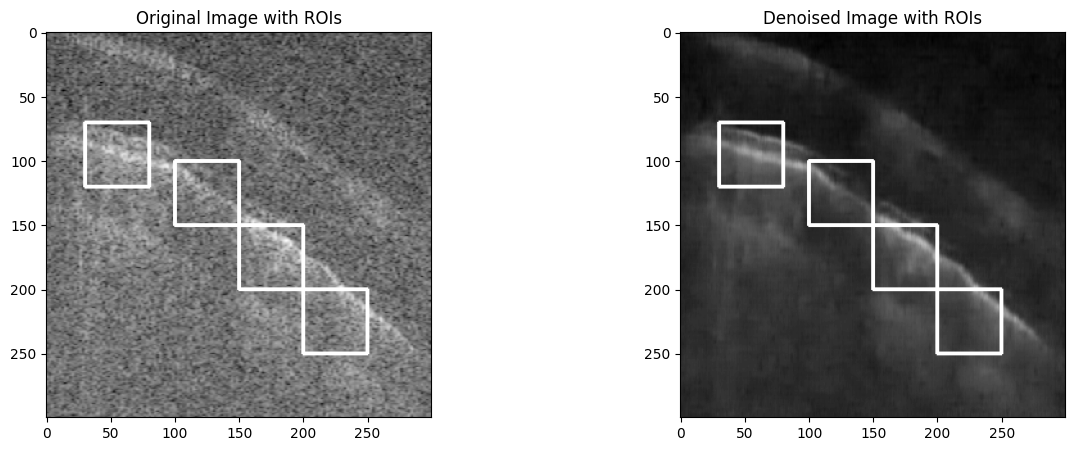

ROI (30, 70, 50, 50): MSR=0.9893716500715696, TP=0.9508911178719481, EP=0.01457478758831738
ROI (100, 100, 50, 50): MSR=1.0011276328474188, TP=0.9460205883593615, EP=0.04931273633295657
ROI (150, 150, 50, 50): MSR=0.9915687151011212, TP=0.9526919837975943, EP=0.053617701655710406
ROI (200, 200, 50, 50): MSR=0.9964627851519301, TP=0.9399328981172878, EP=0.06012742892276309


In [68]:
import numpy as np
import cv2
from skimage import measure
from skimage.feature import local_binary_pattern
from skimage import metrics

def calculate_cnr(signal_roi, background_roi):
    signal_mean = np.mean(signal_roi)
    background_mean = np.mean(background_roi)
    signal_std = np.std(signal_roi)
    background_std = np.std(background_roi)
    cnr = np.abs(signal_mean - background_mean) / np.sqrt(signal_std**2 + background_std**2)
    return cnr

def calculate_msr(original_roi, denoised_roi):
    original_mean = np.mean(original_roi)
    denoised_mean = np.mean(denoised_roi)
    msr = denoised_mean / original_mean
    return msr

def calculate_tp(original_roi, denoised_roi):
    # Compute the LBP for texture comparison
    radius = 1
    n_points = 8 * radius
    lbp_original = local_binary_pattern(original_roi, n_points, radius, method='uniform')
    lbp_denoised = local_binary_pattern(denoised_roi, n_points, radius, method='uniform')
    
    # Compare LBP histograms
    original_hist, _ = np.histogram(lbp_original.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    denoised_hist, _ = np.histogram(lbp_denoised.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalize histograms
    original_hist = original_hist.astype('float') / original_hist.sum()
    denoised_hist = denoised_hist.astype('float') / denoised_hist.sum()

    # Compute the similarity (using chi-square)
    chi_square = 0.5 * np.sum(((original_hist - denoised_hist) ** 2) / (original_hist + denoised_hist + 1e-10))
    tp = 1 - chi_square  # Higher value means better preservation
    return tp

def calculate_ep(original_edges, denoised_edges):
    # Using structural similarity for edge preservation measure
    ep = metrics.structural_similarity(original_edges, denoised_edges, full=True)
    return ep

def process_image(image_path, denoised_image_path, rois):
    original_img = image_path
    denoised_img = denoised_image_path

    metrics = []

    for roi in rois:
        x, y, w, h = roi
        original_roi = original_img[y:y+h, x:x+w]
        denoised_roi = denoised_img[y:y+h, x:x+w]

        # Assume the first ROI is the signal and the second is the background for CNR
        signal_roi = original_roi
        background_roi = denoised_roi

        cnr = calculate_cnr(signal_roi, background_roi)
        msr = calculate_msr(original_roi, denoised_roi)
        tp = calculate_tp(original_roi, denoised_roi)

        # Edge preservation using Canny edge detection
        original_edges = cv2.Canny(original_roi, 100, 200)
        denoised_edges = cv2.Canny(denoised_roi, 100, 200)
        ep = calculate_ep(original_edges, denoised_edges)

        metrics.append({
            'ROI': roi,
            'CNR': cnr,
            'MSR': msr,
            'TP': tp,
            'EP': ep
        })

    return metrics
def mark_roi(image, roi, color=(255, 0, 0)):
    x, y, w, h = roi
    marked_image = image.copy()
    cv2.rectangle(marked_image, (x, y), (x + w, y + h), color, 2)
    return marked_image
def display_images_with_rois(original_img, denoised_img, rois):
    # Mark ROIs
    marked_original = original_img
    marked_denoised = denoised_img
    for roi in rois:
        marked_original = mark_roi(marked_original, roi)
        marked_denoised = mark_roi(marked_denoised, roi)

    # Display the images
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(marked_original, cmap='gray')
    plt.title('Original Image with ROIs')
    plt.axis('on')
    
    plt.subplot(1, 2, 2)
    plt.imshow(marked_denoised, cmap='gray')
    plt.title('Denoised Image with ROIs')
    plt.axis('on')
    
    plt.show()

# Example usage
image_path = eval_img[0]
denoised_image_path = eval_img[1]
rois = [
    (30,70, 50, 50),  
    (100, 100, 50,50), 
    (150,150, 50,50),
    (200,200,50,50)
]
display_images_with_rois(image_path, denoised_image_path, rois)
metrics = process_image(image_path, denoised_image_path, rois)


for metric in metrics:
    print(f"ROI {metric['ROI']}: MSR={metric['MSR']}, TP={metric['TP']}, EP={metric['EP'][0]}")


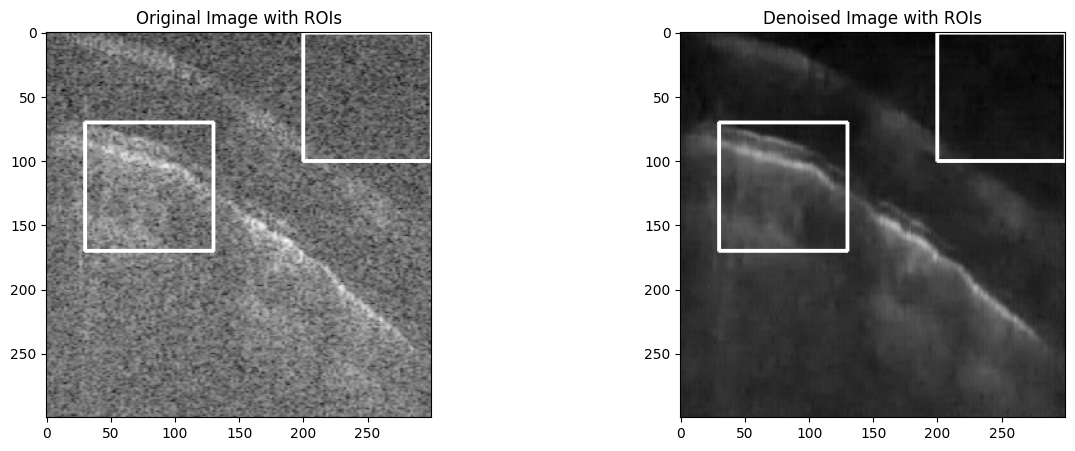

Original Image CNR: 1.068434717279353
Denoised Image CNR: 1.6819942737412723


In [71]:
import numpy as np
import cv2

def mark_roi(image, roi, color=(255, 0, 0)):
    x, y, w, h = roi
    marked_image = image.copy()
    cv2.rectangle(marked_image, (x, y), (x + w, y + h), color, 2)
    return marked_image
def calculate_cnr(signal_roi, background_roi):
    signal_mean = np.mean(signal_roi)
    background_mean = np.mean(background_roi)
    signal_std = np.std(signal_roi)
    background_std = np.std(background_roi)
    cnr = np.abs(signal_mean - background_mean) / np.sqrt(signal_std**2 + background_std**2)
    return cnr

def process_image(image_path, denoised_image_path, signal_roi, background_roi):
    original_img = image_path
    denoised_img = denoised_image_path

    x, y, w, h = signal_roi
    original_signal_roi = original_img[y:y+h, x:x+w]
    denoised_signal_roi = denoised_img[y:y+h, x:x+w]

    x, y, w, h = background_roi
    original_background_roi = original_img[y:y+h, x:x+w]
    denoised_background_roi = denoised_img[y:y+h, x:x+w]

    cnr_original = calculate_cnr(original_signal_roi, original_background_roi)
    cnr_denoised = calculate_cnr(denoised_signal_roi, denoised_background_roi)

    return cnr_original, cnr_denoised
def display_images_with_rois(original_img, denoised_img, signal_roi, background_roi):
    # Mark ROIs
    marked_original = mark_roi(original_img, signal_roi)
    marked_original = mark_roi(marked_original, background_roi)
    marked_denoised = mark_roi(denoised_img, signal_roi)
    marked_denoised = mark_roi(marked_denoised, background_roi)

    # Display the images
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(marked_original, cmap='gray')
    plt.title('Original Image with ROIs')
    plt.axis('on')
    
    plt.subplot(1, 2, 2)
    plt.imshow(marked_denoised, cmap='gray')
    plt.title('Denoised Image with ROIs')
    plt.axis('on')
    
    plt.show()

# Example usage
image_path = eval_img[0]
denoised_image_path = eval_img[1]

# Define the ROIs (x, y, width, height)
signal_roi = (30,70, 100, 100)  # Foreground ROI
background_roi = (200,0 , 100, 100)  # Background ROI

cnr_original, cnr_denoised = process_image(image_path, denoised_image_path, signal_roi, background_roi)
display_images_with_rois(image_path, denoised_image_path, signal_roi, background_roi)
print(f"Original Image CNR: {cnr_original}")
print(f"Denoised Image CNR: {cnr_denoised}")


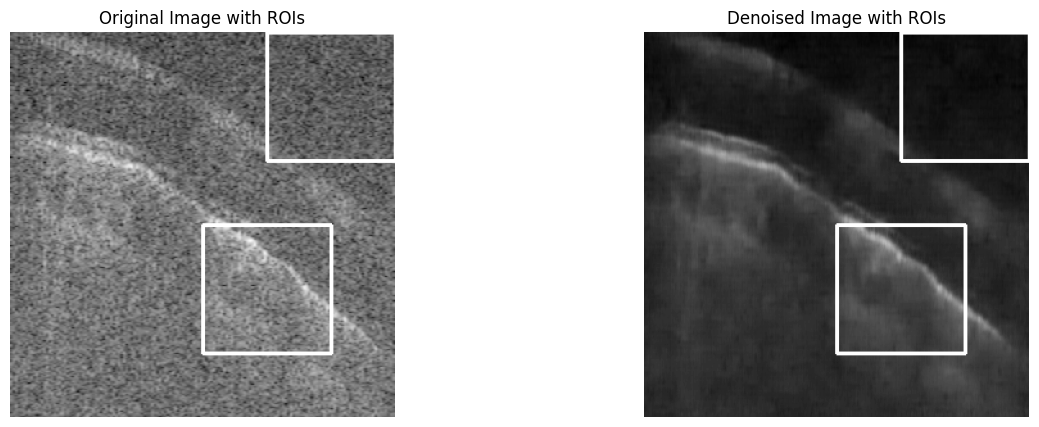

CNR_Original: 1.2116
CNR_Denoised: 1.9739
MSR: 0.9955
TP: 0.9488
EP: 0.0382


In [51]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

def calculate_cnr(signal_roi, background_roi):
    signal_mean = np.mean(signal_roi)
    background_mean = np.mean(background_roi)
    signal_std = np.std(signal_roi)
    background_std = np.std(background_roi)
    cnr = np.abs(signal_mean - background_mean) / np.sqrt(signal_std**2 + background_std**2)
    return cnr

def calculate_msr(original_roi, denoised_roi):
    original_mean = np.mean(original_roi)
    denoised_mean = np.mean(denoised_roi)
    msr = denoised_mean / original_mean
    return msr

def calculate_tp(original_roi, denoised_roi):
    # Compute the LBP for texture comparison
    radius = 1
    n_points = 8 * radius
    lbp_original = local_binary_pattern(original_roi, n_points, radius, method='uniform')
    lbp_denoised = local_binary_pattern(denoised_roi, n_points, radius, method='uniform')
    
    # Compare LBP histograms
    original_hist, _ = np.histogram(lbp_original.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    denoised_hist, _ = np.histogram(lbp_denoised.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalize histograms
    original_hist = original_hist.astype('float') / original_hist.sum()
    denoised_hist = denoised_hist.astype('float') / denoised_hist.sum()

    # Compute the similarity (using chi-square)
    chi_square = 0.5 * np.sum(((original_hist - denoised_hist) ** 2) / (original_hist + denoised_hist + 1e-10))
    tp = 1 - chi_square  # Higher value means better preservation
    return tp

def calculate_ep(original_image, denoised_image):
    # Edge detection using Canny
    edges_original = cv2.Canny(original_image, 100, 200)
    edges_denoised = cv2.Canny(denoised_image, 100, 200)

    # Calculate SSIM for edge preservation
    ep_value, _ = ssim(edges_original, edges_denoised, full=True)
    return ep_value

def mark_roi(image, roi, color=(255, 0, 0)):
    x, y, w, h = roi
    marked_image = image.copy()
    cv2.rectangle(marked_image, (x, y), (x + w, y + h), color, 2)
    return marked_image

def process_image(image_path, denoised_image_path, signal_roi, background_roi):
    original_img = image_path
    denoised_img = denoised_image_path

    x, y, w, h = signal_roi
    original_signal_roi = original_img[y:y+h, x:x+w]
    denoised_signal_roi = denoised_img[y:y+h, x:x+w]

    x, y, w, h = background_roi
    original_background_roi = original_img[y:y+h, x:x+w]
    denoised_background_roi = denoised_img[y:y+h, x:x+w]

    cnr_original = calculate_cnr(original_signal_roi, original_background_roi)
    cnr_denoised = calculate_cnr(denoised_signal_roi, denoised_background_roi)

    msr = calculate_msr(original_signal_roi, denoised_signal_roi)
    tp = calculate_tp(original_signal_roi, denoised_signal_roi)
    ep = calculate_ep(original_img, denoised_img)

    return {
        'CNR_Original': cnr_original,
        'CNR_Denoised': cnr_denoised,
        'MSR': msr,
        'TP': tp,
        'EP': ep
    }, original_img, denoised_img

def display_images_with_rois(original_img, denoised_img, signal_roi, background_roi):
    # Mark ROIs
    marked_original = mark_roi(original_img, signal_roi)
    marked_original = mark_roi(marked_original, background_roi)
    marked_denoised = mark_roi(denoised_img, signal_roi)
    marked_denoised = mark_roi(marked_denoised, background_roi)

    # Display the images
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(marked_original, cmap='gray')
    plt.title('Original Image with ROIs')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(marked_denoised, cmap='gray')
    plt.title('Denoised Image with ROIs')
    plt.axis('off')
    
    plt.show()

image_path = eval_img[0]
denoised_image_path = eval_img[1]

# Define the ROIs (x, y, width, height)
signal_roi = (150,150, 100, 100)  # Foreground ROI
background_roi = (200,0 , 100, 100) # Background ROI

metrics, original_img, denoised_img = process_image(image_path, denoised_image_path, signal_roi, background_roi)
display_images_with_rois(original_img, denoised_img, signal_roi, background_roi)

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


In [6]:
!zip -r denised-train.zip /kaggle/working/kaggle/working/denoised/ICIP_test_data_final

updating: kaggle/working/kaggle/working/denoised/ICIP_test_data_final/ (stored 0%)
  adding: kaggle/working/kaggle/working/denoised/ICIP_test_data_final/RawDataQA (3)/ (stored 0%)
  adding: kaggle/working/kaggle/working/denoised/ICIP_test_data_final/RawDataQA (3)/(67).tif (deflated 51%)
  adding: kaggle/working/kaggle/working/denoised/ICIP_test_data_final/RawDataQA (3)/(133).tif (deflated 53%)
  adding: kaggle/working/kaggle/working/denoised/ICIP_test_data_final/RawDataQA (3)/(171).tif (deflated 54%)
  adding: kaggle/working/kaggle/working/denoised/ICIP_test_data_final/RawDataQA (3)/(256).tif (deflated 53%)
  adding: kaggle/working/kaggle/working/denoised/ICIP_test_data_final/RawDataQA (3)/(76).tif (deflated 49%)
  adding: kaggle/working/kaggle/working/denoised/ICIP_test_data_final/RawDataQA (3)/(160).tif (deflated 55%)
  adding: kaggle/working/kaggle/working/denoised/ICIP_test_data_final/RawDataQA (3)/(125).tif (deflated 52%)
  adding: kaggle/working/kaggle/working/denoised/ICIP_test_